In [19]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold, ParameterGrid
from sklearn.metrics import (make_scorer, mean_absolute_error, mean_squared_error, 
                             balanced_accuracy_score, classification_report, confusion_matrix, accuracy_score) 


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def get_report(y_true, y_pred):
    print("Test accuracy: ", balanced_accuracy_score(y_true, y_pred))
    print("Report: ")
    print(classification_report(y_true, y_pred))
    print("Confusion matrix:")
    print(confusion_matrix(y_true, y_pred))

In [4]:
RS = 42

In [5]:
df_features = pd.read_csv("features.csv", index_col=0)
labels = pd.read_csv('../data/labels.csv', index_col=0)[['citation_class']]

df = labels.join(df_features)

In [6]:
df = df.iloc[1000:-100]  # throw away some of the first and some of the last activities

In [7]:
X, y = df.iloc[:, 1:].values, df.citation_class.values.reshape(-1, 1)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=RS, shuffle=True)

In [9]:
gbm = lgb.LGBMClassifier(class_weight='balanced', random_state=RS)
gbm.fit(X_train,y_train)

LGBMClassifier(class_weight='balanced', random_state=42)

In [10]:
y_pred = gbm.predict(X_test)
print(f"Train accuracy: {balanced_accuracy_score(y_train, gbm.predict(X_train))}")
get_report(y_test, y_pred)  

Train accuracy: 0.7820195077150469
Test accuracy:  0.6459876218426789
Report: 
              precision    recall  f1-score   support

           0       0.89      0.77      0.83      5388
           1       0.36      0.50      0.42      1317
           2       0.42      0.66      0.51       372

    accuracy                           0.72      7077
   macro avg       0.56      0.65      0.59      7077
weighted avg       0.77      0.72      0.74      7077

Confusion matrix:
[[4160 1078  150]
 [ 462  661  194]
 [  41   84  247]]


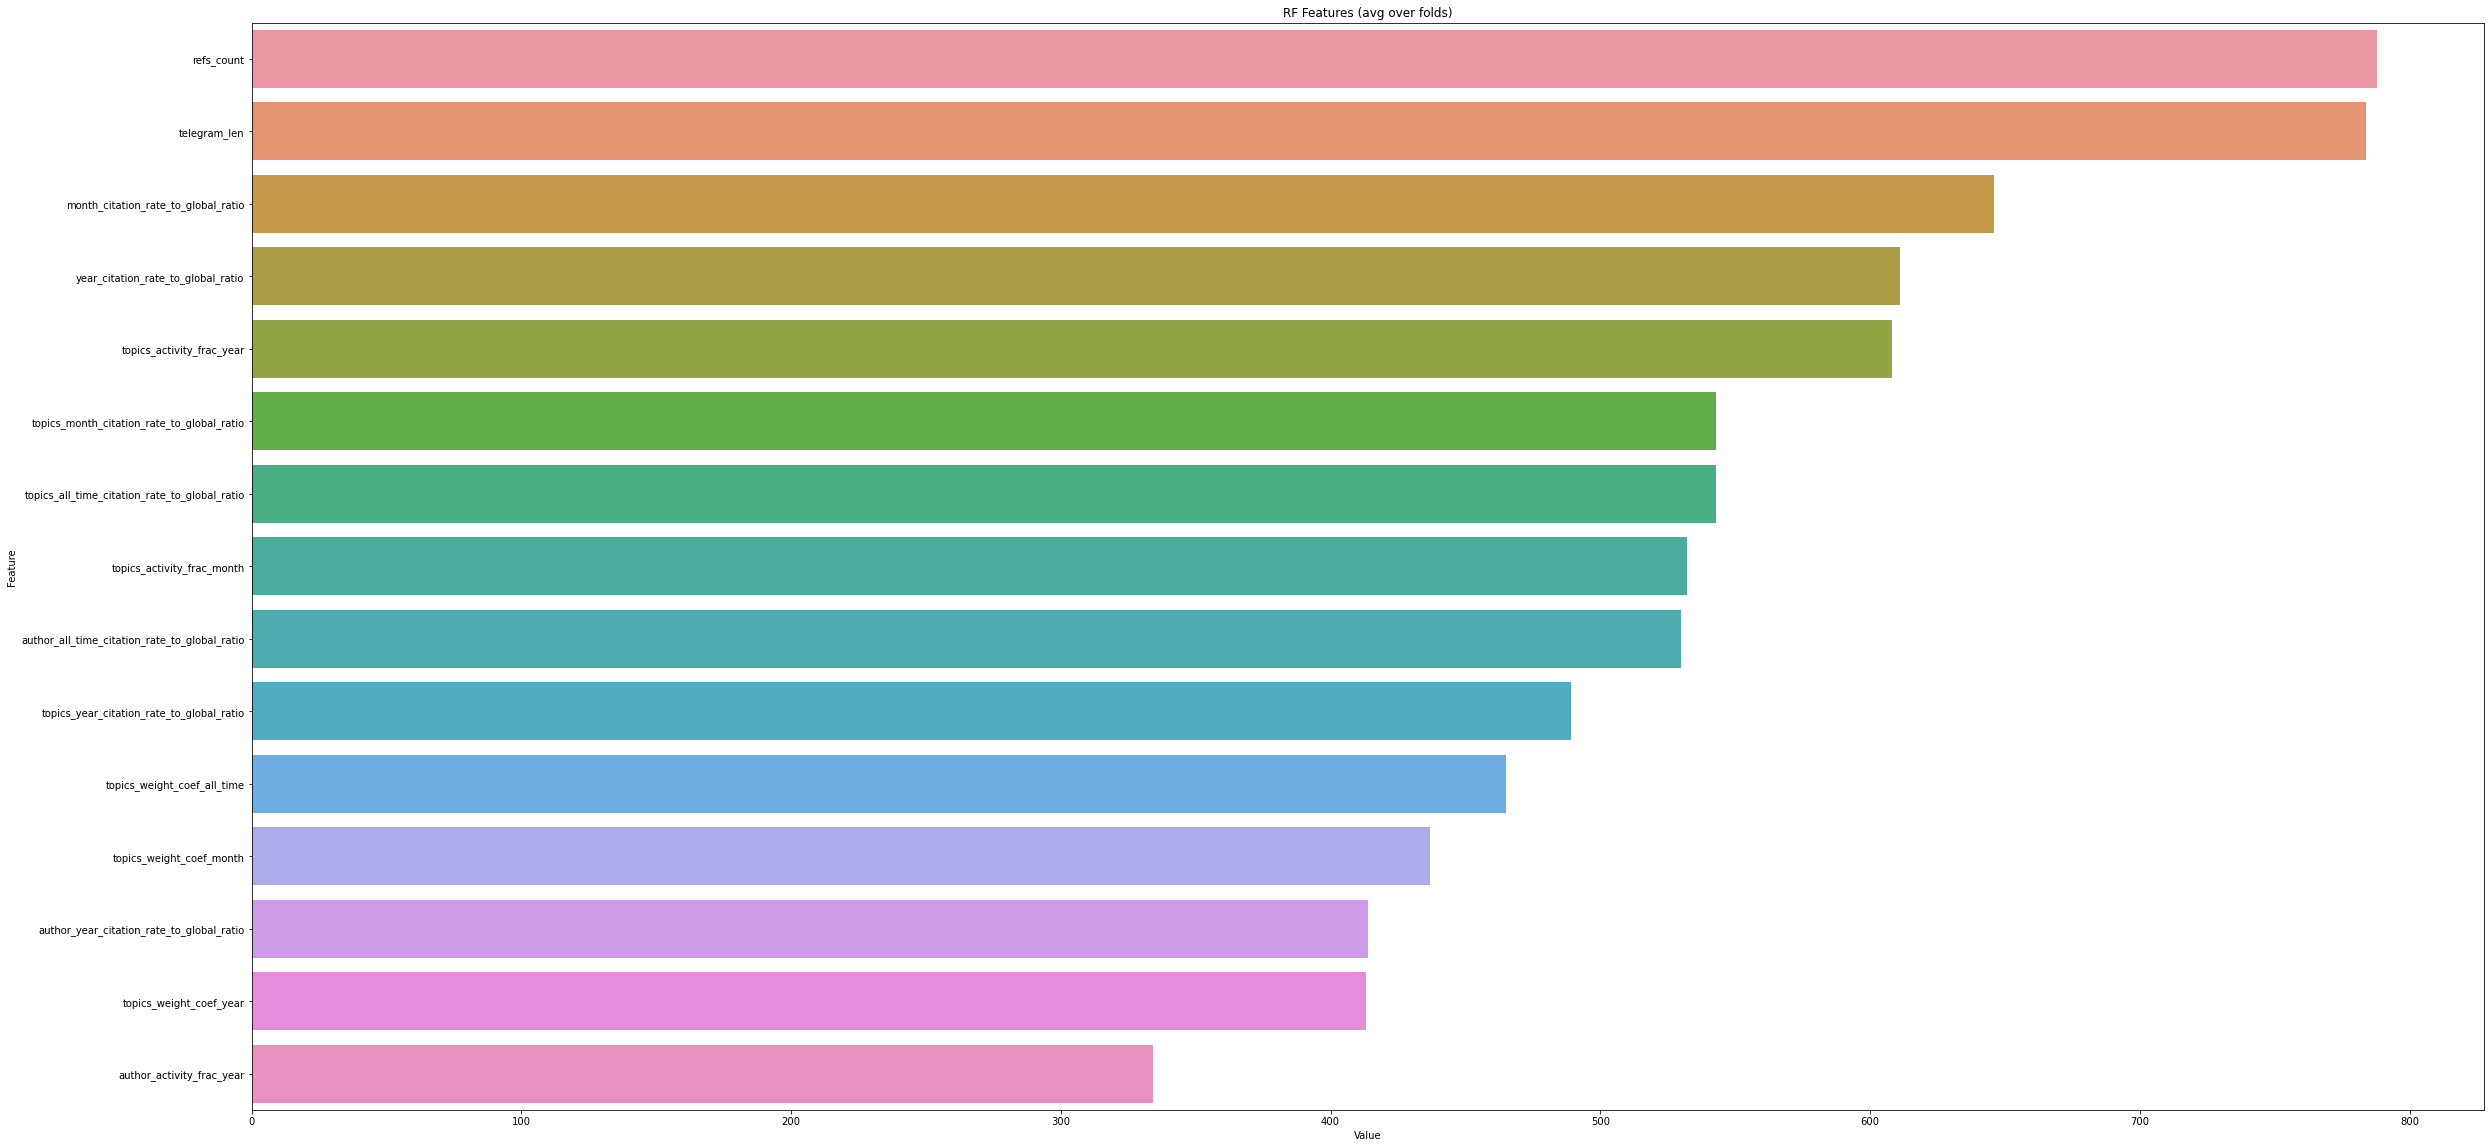

In [11]:
feature_imp = pd.DataFrame({'Value': gbm.feature_importances_, 'Feature': df.iloc[:, 1:].columns})

plt.figure(figsize=(40, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:15])
plt.title('RF Features (avg over folds)')
plt.show()

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=RS)
# X_train, y_train = ros.fit_resample(X_train, y_train)

NFOLDS = 4
kf = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=RS)

scorer = make_scorer(balanced_accuracy_score, greater_is_better=True)  

model = lgb.LGBMClassifier(class_weight='balanced', random_state=RS)

parameters = {
    'n_estimators': [100, 250, 500, 1000],
    'max_depth': [2, 4, 6, -1],
    'reg_alpha': [0.1, 1],
    'learning_rate': [0.001, 0.01, 0.1]
}

RSCV = RandomizedSearchCV(model, parameters, scoring=scorer, cv=kf, n_iter=333, verbose=1)

In [13]:
RSCV.fit(X_train, y_train)

Fitting 4 folds for each of 96 candidates, totalling 384 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
                   estimator=LGBMClassifier(class_weight='balanced',
                                            random_state=42),
                   n_iter=333,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.1],
                                        'max_depth': [2, 4, 6, -1],
                                        'n_estimators': [100, 250, 500, 1000],
                                        'reg_alpha': [0.1, 1]},
                   scoring=make_scorer(balanced_accuracy_score), verbose=1)

In [14]:
best_estimator = RSCV.best_estimator_

y_pred = best_estimator.predict(X_test)
print(f"Train accuracy: {balanced_accuracy_score(y_train, best_estimator.predict(X_train))}")
get_report(y_test, y_pred)

Train accuracy: 0.7168171629498327
Test accuracy:  0.6436282085768351
Report: 
              precision    recall  f1-score   support

           0       0.89      0.76      0.82      5388
           1       0.34      0.48      0.40      1317
           2       0.39      0.69      0.50       372

    accuracy                           0.70      7077
   macro avg       0.54      0.64      0.57      7077
weighted avg       0.76      0.70      0.72      7077

Confusion matrix:
[[4073 1143  172]
 [ 454  634  229]
 [  37   77  258]]


In [15]:
RSCV.best_params_ 

{'reg_alpha': 1, 'n_estimators': 500, 'max_depth': -1, 'learning_rate': 0.01}

In [17]:
# to binary and check the metrics

In [16]:
y_pred_binary = (y_pred > 0).astype(int)
y_test_binary = (y_test > 0).astype(int)

In [18]:
get_report(y_test_binary, y_pred_binary)

Test accuracy:  0.7326172825343076
Report: 
              precision    recall  f1-score   support

           0       0.89      0.76      0.82      5388
           1       0.48      0.71      0.57      1689

    accuracy                           0.74      7077
   macro avg       0.68      0.73      0.69      7077
weighted avg       0.79      0.74      0.76      7077

Confusion matrix:
[[4073 1315]
 [ 491 1198]]
